In [1]:
import os
import glob

import pandas as pd
import numpy as np
import rasterio as rio

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from scipy import stats
#import statannotations
from statannot import add_stat_annotation

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import imblearn as imb
from imblearn.under_sampling import RandomUnderSampler

import scipy

In [2]:
def img_to_df(img_path, cols):
    with rio.open(img_path) as src:
        as_array = src.read()
        band_arrs = []
        
        for i in np.arange(src.count):
            band_arr = as_array[i].flatten()
            band_arr = band_arr/10000
            
            band_arrs.append(band_arr)
        
        df = pd.DataFrame(band_arrs,cols).T
        df['Date'] = img_path.split('/')[-1].split('_')[0]
        
        # Optional: drops entries with no severity rating. Comment out if unnecessary.
        no_nans = df.dropna(subset=['total_dis_sev']) 
        
        return no_nans

In [3]:
def add_vis(df):
    df['pri']= (df['green']- df['greenI'])/(df['green']+df['greenI'])
    df['ndre'] = (df['nir'] - df['rede']) / (df['nir'] + df['rede'])
    df['tcari'] = 3 * (( (df['rede'] - df['red']) - 0.2 * (df['rede'] - df['green']) ) * (df['rede'] / df['red']))
    df['ndvi']= (df['nir']-df['red'])/(df['nir']+df['red'])
    df['evi']= 2.5*(df['nir']-df['red'])/(df['nir']+6*df['red']-7.5*df['blue']+1)
    df['savi']= 1.5*(df['nir']-df['red'])/(df['nir']+df['red']+0.5)
    df['arvi']=(df['nir']-(2*df['red']-df['blue']))/(df['nir']+(2*df['red']-df['blue']))
    df['green_red'] = (df['green']-df['red'])/(df['green']+df['red'])

    return df

In [4]:
data_dir = '/Users/kathleenkanaley/Desktop/grapes_from_space/data/'
#dis_ras_20 = glob.glob(data_dir +'images/2020/PScope/dis_band_*/*.tif')
#dis_ras_21 = glob.glob(data_dir +'images/2021/PScope/dis_band_*/*.tif')
dis_ras_22 = glob.glob(data_dir +'images/2022/PScope/dis_band_*/*.tif')

In [5]:
cols = ['c_blue','blue','greenI', 'green', 'yellow', 'red', 'rede', 'nir','total_dis_sev','dm_sev', 'dm_inc']

# Get a dataframe for all 2020 images

dfs_2022 = [img_to_df(dis_ras_22[i], cols) for i in np.arange(len(dis_ras_22))]
df_2022 = pd.concat(dfs_2022)

df_2022['total_dis_sev'] = df_2022['total_dis_sev']*10000
df_2022['dm_sev'] = df_2022['dm_sev']*10000
df_2022['dm_inc'] = df_2022['dm_inc']*10000

df_2022['inc_class'] = 'low'
df_2022.loc[df_2022['dm_inc']>25,'inc_class']= 'high'
    
df_2022['severity_class'] = 'low'
df_2022.loc[df_2022['dm_sev']>10,'severity_class']= 'high'

vis_2022 = add_vis(df_2022)
vis_2022.columns

Index(['c_blue', 'blue', 'greenI', 'green', 'yellow', 'red', 'rede', 'nir',
       'total_dis_sev', 'dm_sev', 'dm_inc', 'Date', 'inc_class',
       'severity_class', 'pri', 'ndre', 'tcari', 'ndvi', 'evi', 'savi', 'arvi',
       'green_red'],
      dtype='object')

In [6]:
vis_2022.Date.unique()

array(['20220726', '20220801', '20220630', '20220704', '20220624'],
      dtype=object)

In [7]:
# SB + VIs 
expl_vars = ['c_blue', 'blue', 'greenI', 'green', 'yellow', 'red', 'rede', 'nir']#,
             #'pri', 'ndre', 'tcari', 'ndvi', 'evi', 'savi', 'arvi','green_red']
resp_var = 'inc_class'

In [8]:
X = vis_2022[expl_vars]
y = vis_2022[resp_var]

rus = RandomUnderSampler(random_state=2022)
X_rus, y_rus = rus.fit_resample(X, y)

# Split dataset into training set and test set
SPLIT_RND_SEED = 456
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                    test_size=0.3, 
                                                    random_state=SPLIT_RND_SEED,
                                                    stratify = y_rus)  # 70% training and 30% test

In [9]:
mm = MinMaxScaler()
X_train_scaled = mm.fit_transform(X_train)
X_test_scaled = mm.transform(X_test)
#y_train = np.array(y_train)

In [10]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)
display(rfc.score(X_train_scaled, y_train))

1.0

In [11]:
# Prediction on test data
y_pred = rfc.predict(X_test_scaled)

In [12]:
# Classification report
stats = classification_report(y_test, y_pred,
                              labels=None,
#                               target_names=["low", "high"],
                              sample_weight=None,
                              digits=2,
                              output_dict=False)
  
print("Classification report:\n")
print(stats)

Classification report:

              precision    recall  f1-score   support

        high       0.79      0.79      0.79        58
         low       0.79      0.79      0.79        58

    accuracy                           0.79       116
   macro avg       0.79      0.79      0.79       116
weighted avg       0.79      0.79      0.79       116



In [13]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000,
num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num =
15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50,
num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50,
num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

In [14]:
rs = RandomizedSearchCV(rfc,
param_dist,
n_iter = 100,
cv = 3,
verbose = 1,
n_jobs=-1,
random_state=0)

rs.fit(X_train_scaled, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 700,
 'min_samples_split': 12,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 13,
 'bootstrap': False}

In [15]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
'mean_fit_time',
'std_fit_time',
'mean_score_time',
'std_score_time',
'params',
'split0_test_score',
'split1_test_score',
'split2_test_score',
'std_test_score'],
axis=1)

rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,700,18,7,sqrt,7,False,0.803704,1
1,700,12,2,sqrt,13,False,0.803704,1
2,700,23,7,log2,15,False,0.800000,3
3,700,2,2,log2,11,True,0.800000,3
4,400,23,2,sqrt,14,False,0.800000,3
5,500,18,7,log2,7,True,0.796296,6
6,1000,12,7,sqrt,10,True,0.792593,7
7,600,23,2,sqrt,15,False,0.788889,8
8,300,28,7,log2,13,True,0.788889,8
9,200,12,2,log2,4,True,0.785185,10


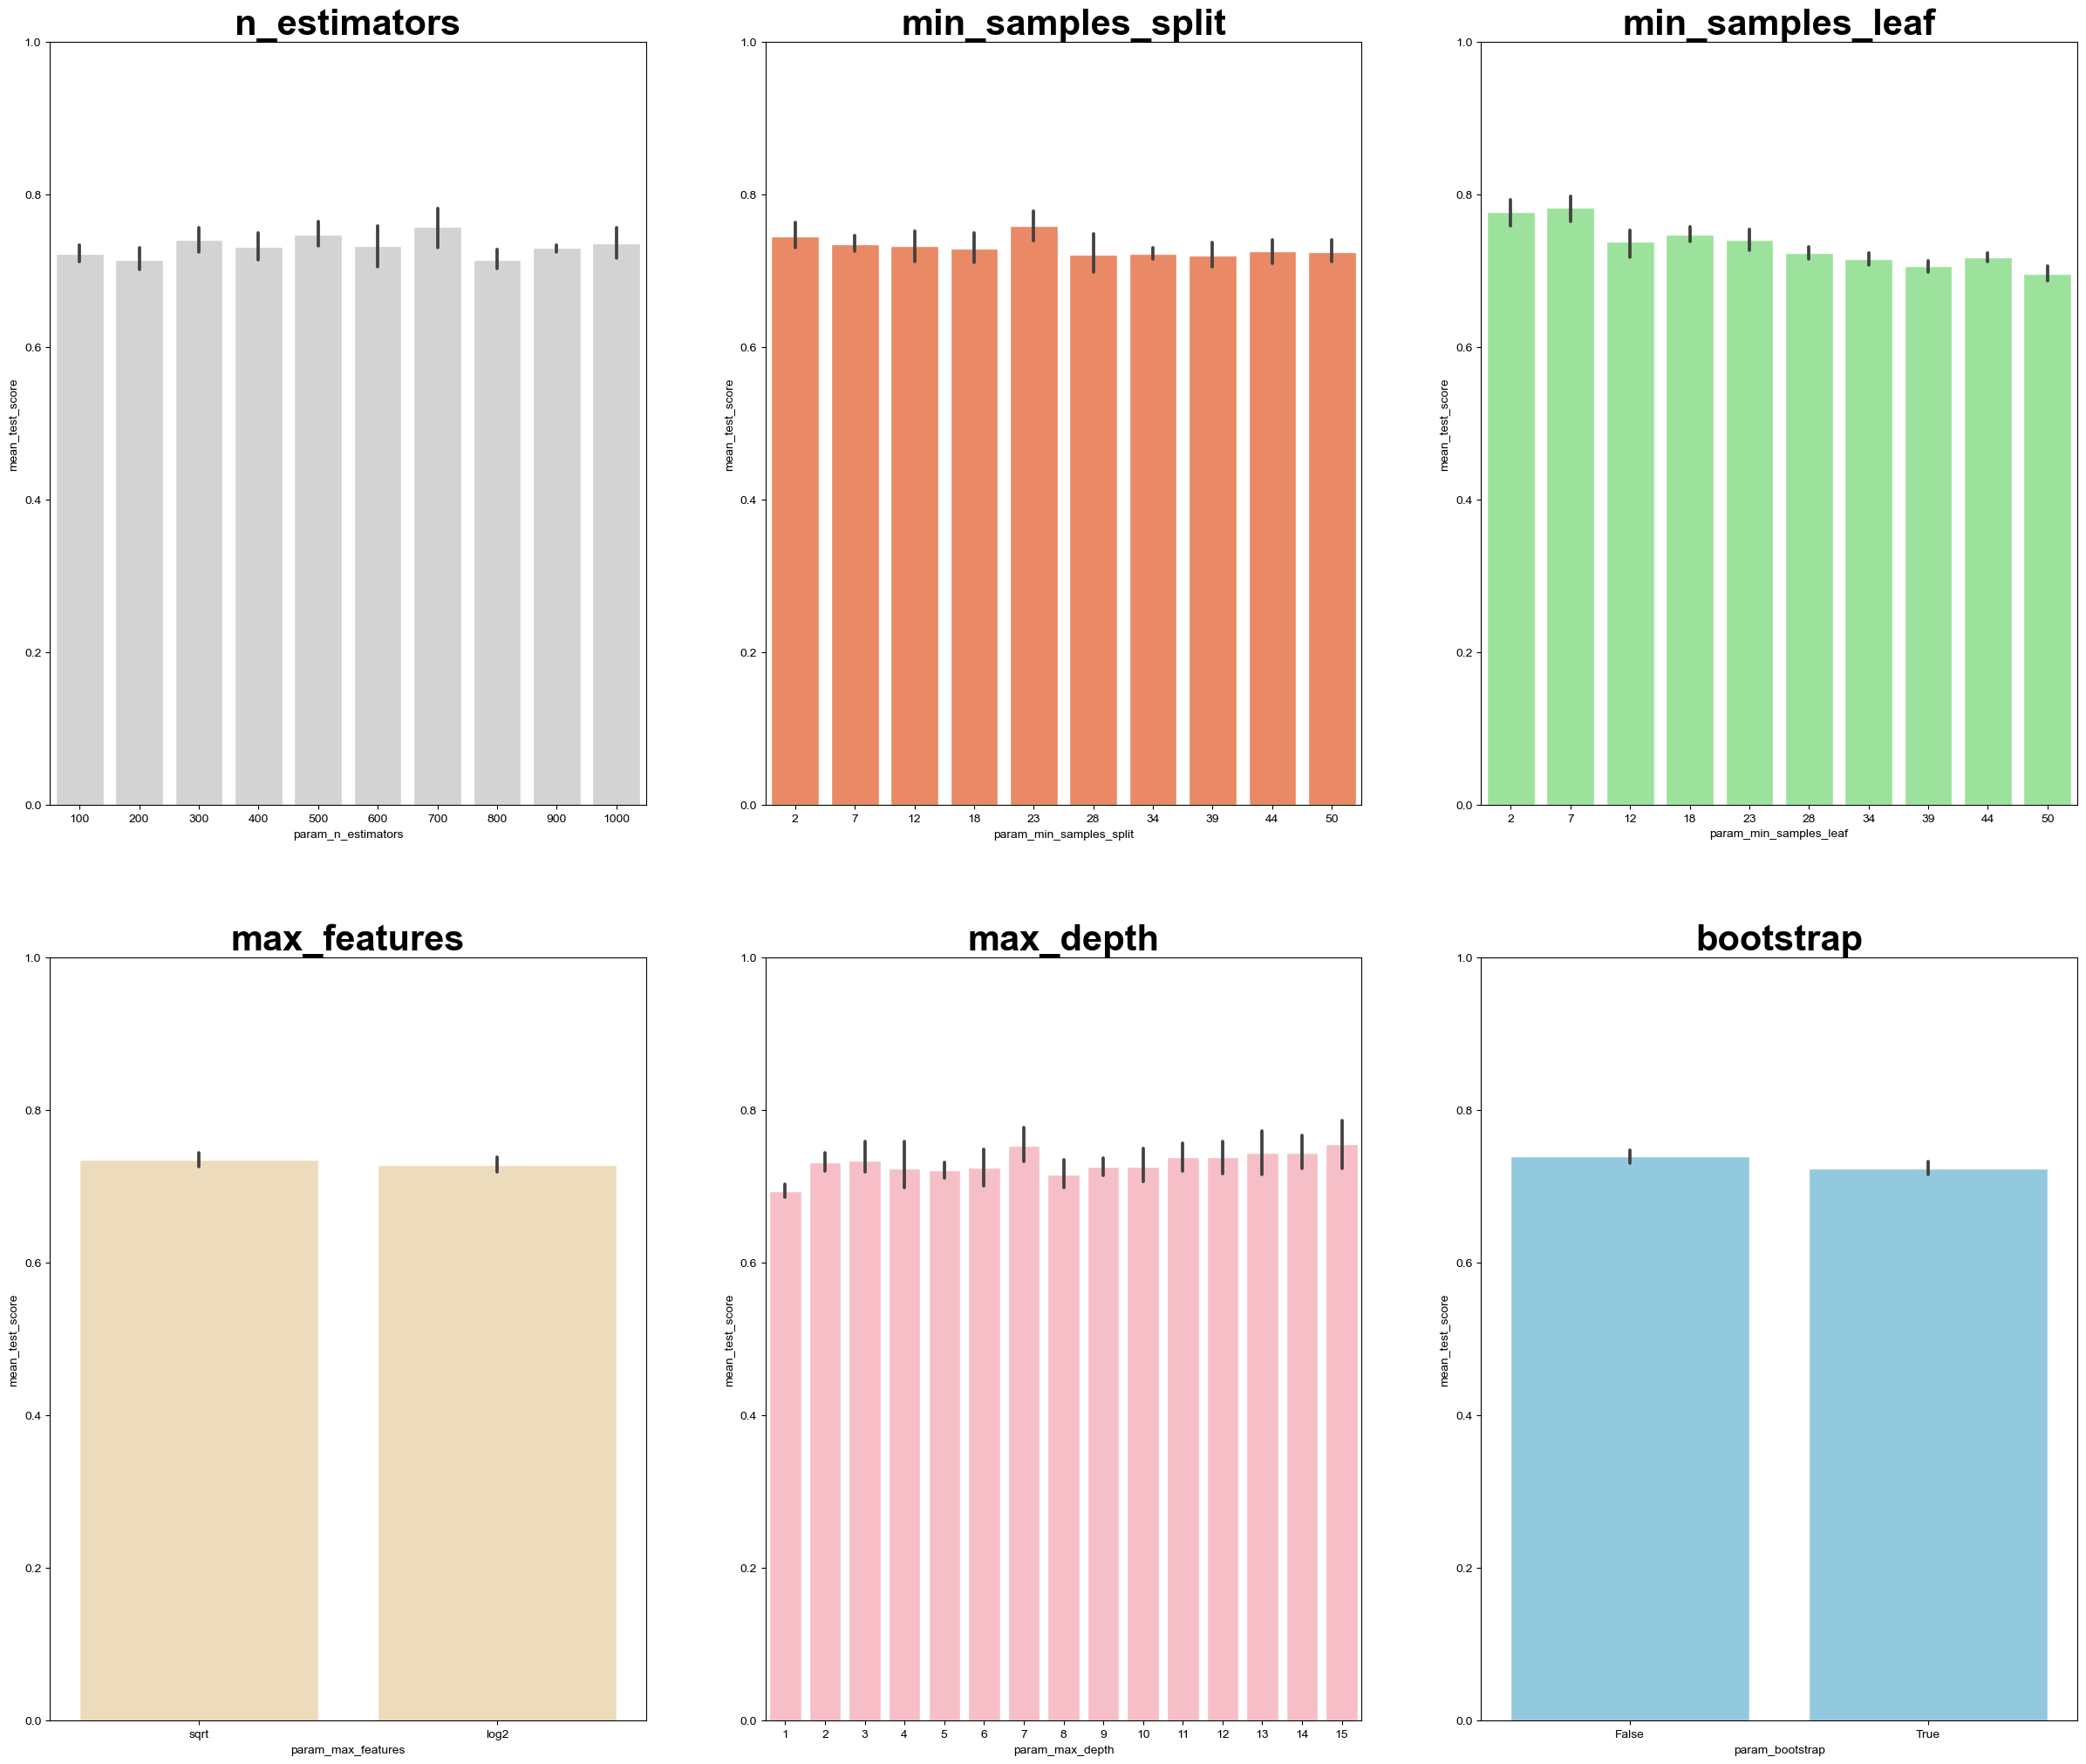

In [16]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df,
ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.0,1])
axs[0,0].set_title(label = 'n_estimators',
size=30, weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score',
data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.0,1])
axs[0,1].set_title(label =
'min_samples_split', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score',
data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.0,1])
axs[0,2].set_title(label =
'min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df,
ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.0,1])
axs[1,0].set_title(label = 'max_features',
size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df,
ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.0,1])
axs[1,1].set_title(label = 'max_depth',
size=30, weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df,
ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.0,1])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')

plt.show()

In [17]:
from sklearn.model_selection import GridSearchCV
n_estimators = [300,500,700]
max_features = ['sqrt']
max_depth = [2,3,7,13,15]
min_samples_split = [2,12,23]
min_samples_leaf = [2,7]
bootstrap = [True,False]

param_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_scaled, y_train)
rfc_2 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 180 candidates, totalling 540 fits


{'bootstrap': False,
 'max_depth': 13,
 'max_features': 'sqrt',
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'n_estimators': 500}

In [18]:
y_pred = rfc.predict(X_test_scaled)

y_pred_gs = gs.best_estimator_.predict(X_test_scaled)

In [19]:
from sklearn.metrics import confusion_matrix

conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred),
index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                   
                                             

conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test, y_pred_gs),
        index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                                         
display(conf_matrix_baseline)
display('Baseline Random Forest accuracy score', accuracy_score(y_test, y_pred))
                                                         

display(conf_matrix_tuned)
display('Hyperparameter Tuned Random Forest accuracy score', accuracy_score(y_test, y_pred_gs))

,high,low
high,46,12
low,12,46


'Baseline Random Forest accuracy score'

0.7931034482758621

,high,low
high,44,14
low,14,44


'Hyperparameter Tuned Random Forest accuracy score'

0.7586206896551724

In [20]:
def run_rf(df, expl_vars, resp_var, SPLIT_RND_SEED):
    X = df[expl_vars]
    y = df[resp_var]
    
    rus = RandomUnderSampler(random_state=2020)
    X_rus, y_rus = rus.fit_resample(X, y)

# Split dataset into training set and test set

    X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                    test_size=0.3, 
                                                    random_state=SPLIT_RND_SEED,
                                                    stratify = y_rus)  # 70% training and 30% test
    mm = MinMaxScaler()
    X_train_scaled = mm.fit_transform(X_train)
    X_test_scaled = mm.transform(X_test)
    
    
    from sklearn.ensemble import RandomForestClassifier
    
    # Modify with best parameters  
    rf = RandomForestClassifier()
        
        
#                                 n_estimators = 500, 
#                                 oob_score=True, 
#                                 #random_state=rand_state, # random number to be used, needed to reproduce the same result
#                                 verbose=False)
    
    rf_model = rf.fit(X_train_scaled, y_train)
    
    y_pred = rf_model.predict(X_test_scaled)
    
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)
    
    from sklearn.metrics import precision_recall_fscore_support
    
    prec, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
  
    
    from sklearn.metrics import cohen_kappa_score
        
    cohen_score = cohen_kappa_score(y_test, y_pred)    

    label_0 = np.unique(y_pred)[0]
    label_1 = np.unique(y_pred)[1]
    
    metrics = {
        'cohen_kappa': [cohen_score], 
        'accuracy_score': [accuracy],
        'precision {}'.format(label_0): [prec[0]],
        'precision {}'.format(label_1): [prec[1]],
        'recall {}'.format(label_0): [recall[0]],
        'recall {}'.format(label_1): [recall[1]],
        'fscore {}'.format(label_0): [fscore[0]],
        'fscore {}'.format(label_1): [fscore[1]],

    }
    metrics_df = pd.DataFrame(data=metrics)
    
    return metrics_df


In [21]:
import random
 
rand_list=[]
n=100
for i in range(n):
    rand_list.append(random.randint(100,999))

In [22]:
# RF model, GDM Inc 2020 SB + VI
# expl_vars = ['blue', 'green', 'red', 'nir','ndvi', 'evi','msavi', 'arvi', 'green_red']
# resp_var = 'GDM_inc'

results_alldata = []
for r in rand_list:
    res_df = run_rf(vis_2022, expl_vars, resp_var, r)
    
    results_alldata.append(res_df)

In [23]:
results_alldata_df = pd.concat(results_alldata)
results_alldata_df.mean()

cohen_kappa       0.595172
accuracy_score    0.797586
precision high    0.811886
precision low     0.788316
recall high       0.778103
recall low        0.817069
fscore high       0.793141
fscore low        0.801183
dtype: float64